# Кластерный анализ временных рядов

In [1]:
import pandas as pd
import numpy as np
import datetime
import preprocess
import clustering
import plot

Загрузим данные и внимательно посмотрим на них. 

In [2]:
trading_session_df = pd.read_csv("data/trading_session.csv")
chart_data_df = pd.read_csv("data/chart_data.csv")

Оставим только месячные сессии. 

In [3]:
trading_session_df = trading_session_df[trading_session_df.trading_type == "monthly"]
chart_data_df = chart_data_df[chart_data_df.session_id.isin(trading_session_df.id)]

Соберем данные в один датафрейм, отсортируем по времени.

In [4]:
summary_df = preprocess.make_summary(trading_session_df, chart_data_df)

Сделаем следующие трансформации:
- Почистим данные, уберем дублирующие сделки
- Уберем сессии, сделки в которых совершались в течение более чем одного часа
- Знаем, что сессий с **platform_id=1** начало происходило в **11 часов**, а для сессий с **platform_id=2** начало было в **12 часов**. Уберем сделки, которые не попадают в этот временной интервал

In [5]:
summary_df = summary_df.drop_duplicates(subset=["deal_id"])
summary_df = preprocess.remove_long_sessions(summary_df)
summary_df = preprocess.remove_outliers(summary_df)

Будем делать кластеризацию, используя **price**. Приведем все временные ряды к одному размеру с помощью функции **resample** с интервалом в **1 минуту**. Если в одну минуту происходило несколько сделок, то я использовал среднее по всем сделкам в эту минуту. Также отнормируем каждую сессию на среднее. 

In [6]:
session_ids = np.unique(summary_df.session_id)
time_series = np.array([preprocess.make_time_series(summary_df[summary_df.session_id == session_id]) 
                        for session_id in session_ids])
norm_time_series = time_series - time_series.mean(axis=1).reshape(-1, 1)

Так как требуется провести кластеризацию с различными метриками (косинусное расстоние, DTW и MAE), то требуется выбрать такой алгоритм кластеризации, который поддерживает любую заданную функцию расстояния. Поэтому я выбрал алгоритм **DBSCAN**. Гиперпараметры подбирились вручную, чтобы получилось адекватное количество кластеров. 

Визуализируем полученные результаты. В алгоритме **DBSCAN** есть как обычные кластеры, так и шумовой кластер. Шумовой кластер имеет **label=-1**. Визуализировать будем исходные временные ряды.  

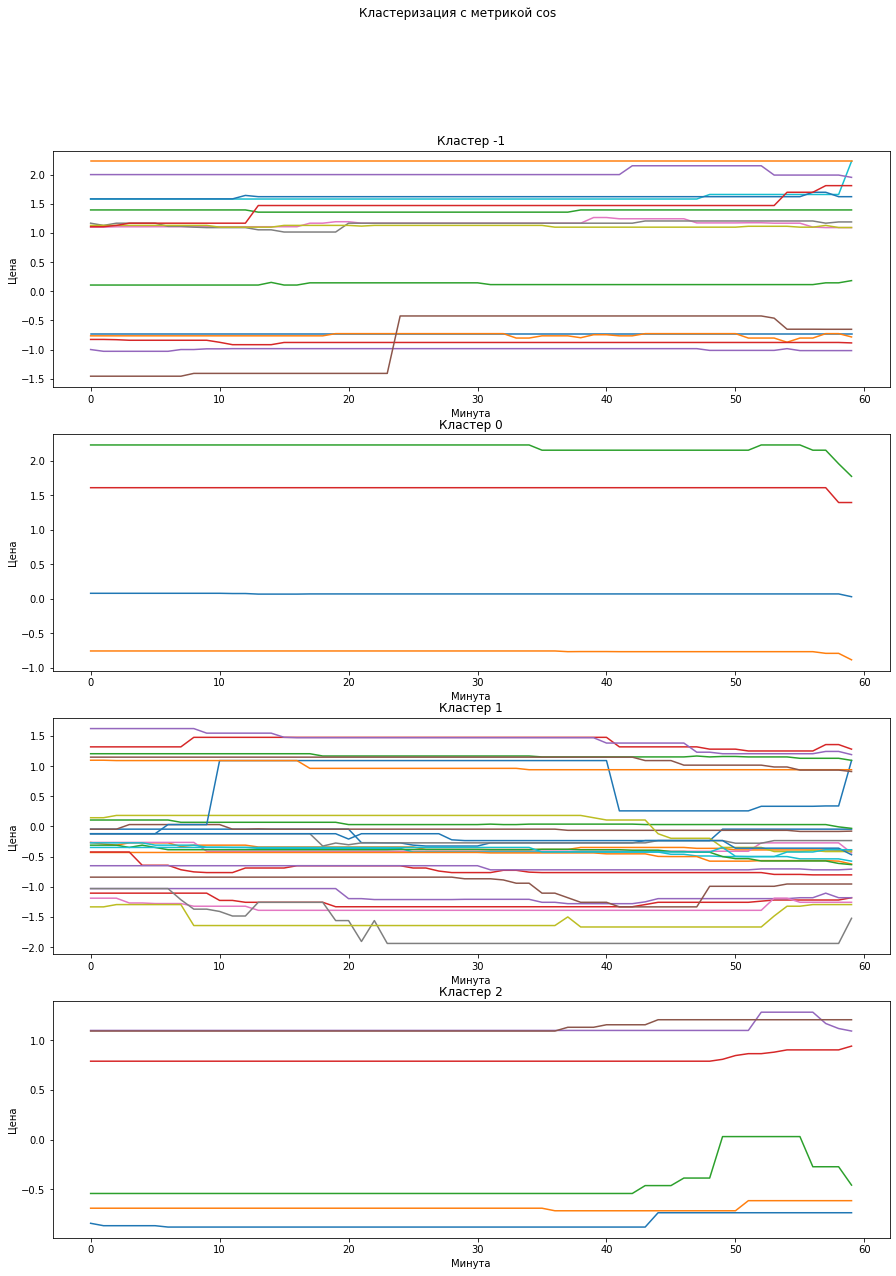

In [7]:
cos_clusters = clustering.cluster(norm_time_series, eps=.3, min_samples=3, metric="cos")
plot.plot_clusters(time_series, cos_clusters, "cos")

Таким образом, с помощью **косинуса** удалось найти **3** кластера. 
- Первый кластер (0) состоит из сессий, в которых почти ничего не происходит 
- Второй кластер (1) трудно однозначно интерпретировать 
- Третий кластер (2) представляет собой сессии, в которых в начале ничего не происходит, но после 40-ой минуты цена идет вверх 

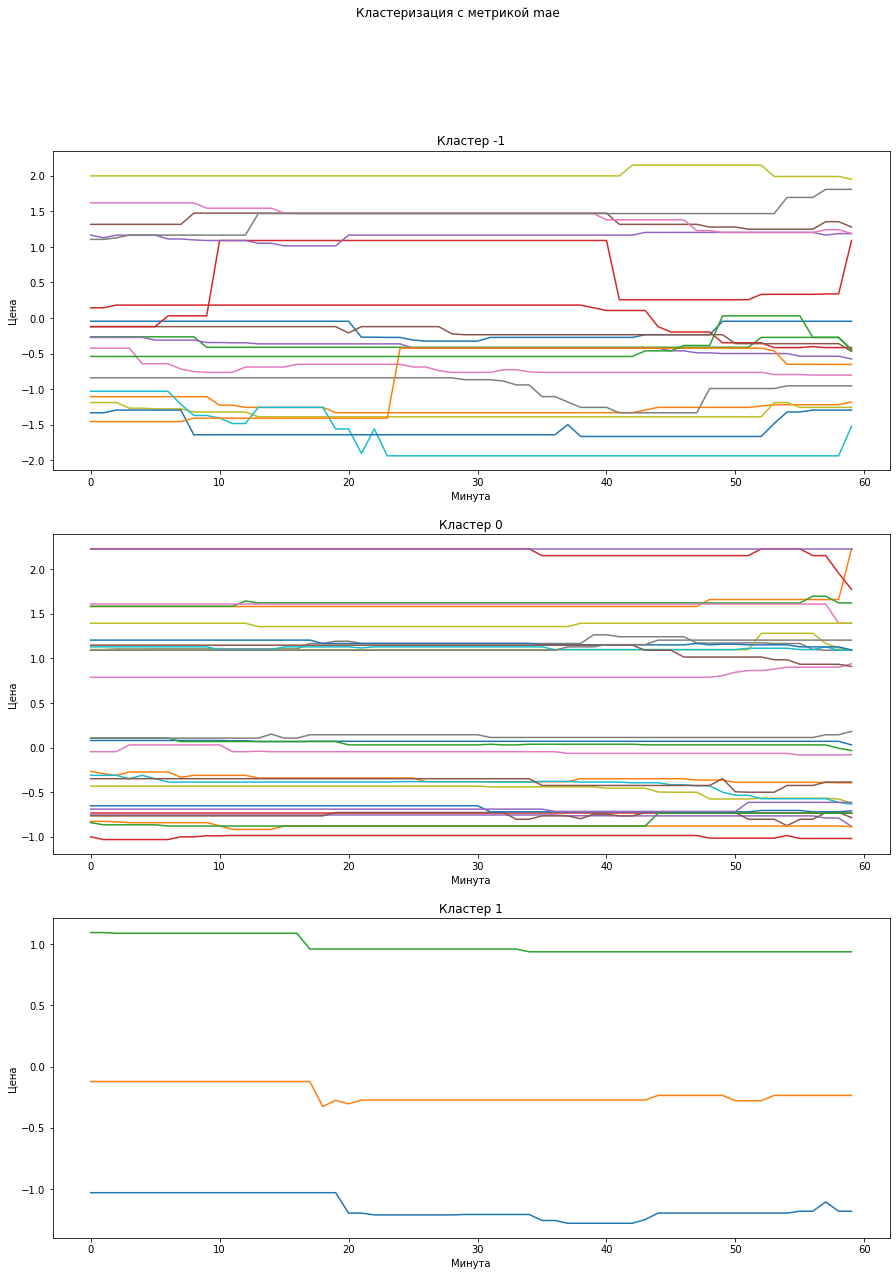

In [8]:
mae_clusters = clustering.cluster(norm_time_series, eps=2, min_samples=3, metric="mae")
plot.plot_clusters(time_series, mae_clusters, "mae")

С помощью **MAE** удалось найти **2** кластера. 
- Первый кластер (0) состоит из несильно колеблющихся сессий
- Второй кластер (1) состоит из трех сессий, в которых на 20-ой минуте произошел небольшой скачок цены вниз, а потом цена опять была стабильна

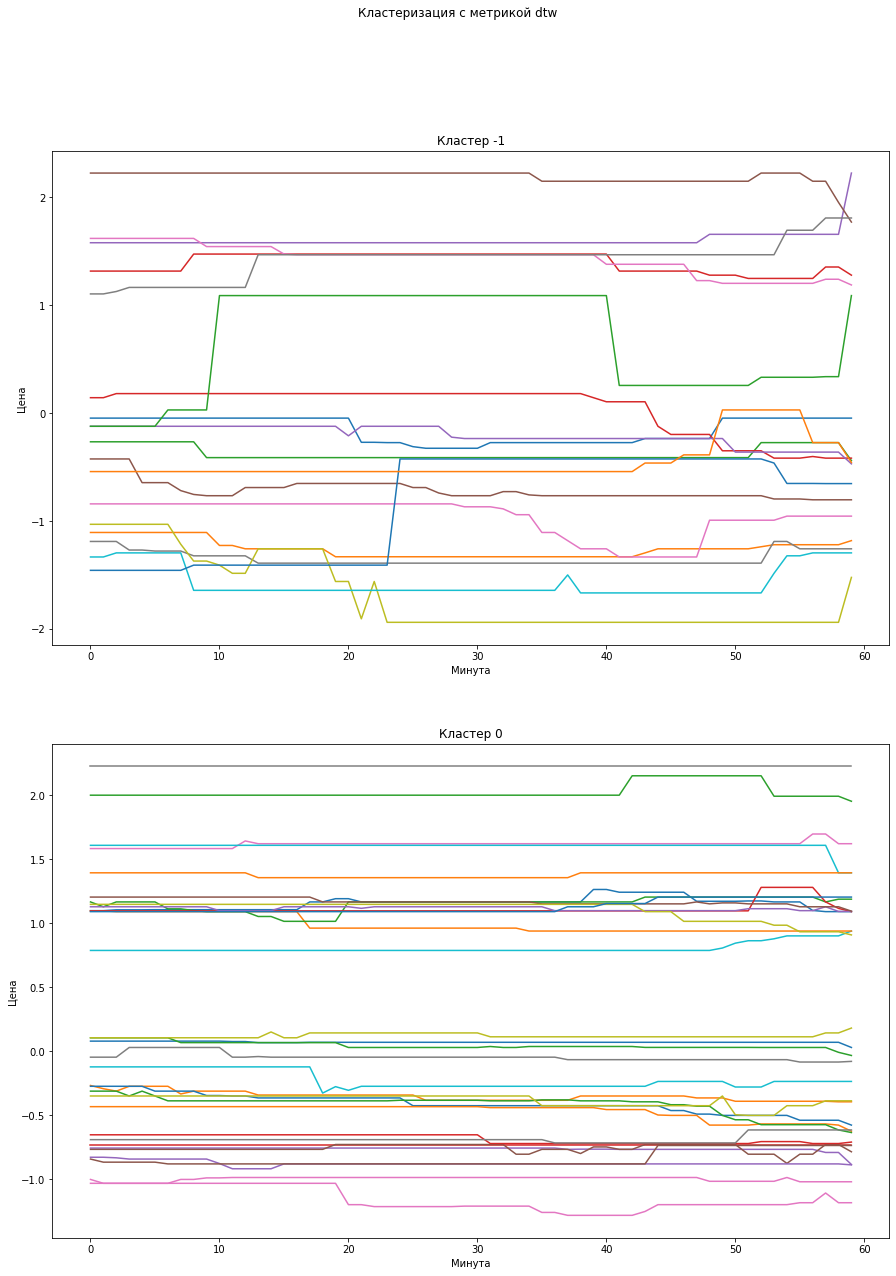

In [9]:
dtw_clusters = clustering.cluster(norm_time_series, eps=.25, min_samples=3, metric="dtw")
plot.plot_clusters(time_series, dtw_clusters, "dtw")

С помощью **DTW** не удалось подобрать такие гиперпарамтеры, чтобы выделились несколько кластеров. Результаты непонятные. 